# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [62]:
% reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [63]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import ast
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [64]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [65]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Number of rows and columns in demographics data are {} and {}, respectively.''\n'.format(azdias.shape[0], azdias.shape[1]))
#print()
print('And number of rows and columns in feature summary data are {} and {}, respectively.'.format(feat_info.shape[0], feat_info.shape[1]))

azdias.head(10)

Number of rows and columns in demographics data are 891221 and 85, respectively.

And number of rows and columns in feature summary data are 85 and 4, respectively.


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [66]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [67]:
feat_info.head(20)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [68]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,CAMEO_DEUG_2015,person,ordinal,[-1]
freq,1,43,49,26


In [69]:
#I was curious to see the frequency of different variable types in the data set
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [70]:
# Identify missing or unknown data values and convert them to NaNs.
for i, column in enumerate(azdias.columns):
    str_n = feat_info['missing_or_unknown'].iloc[i]
    if i in [57, 58, 59]:
        list_n = str_n[1: -1].split(',')
    else:
        list_n = ast.literal_eval(str_n)
    for num in list_n:
        azdias[column].replace(num, np.NaN, inplace = True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [71]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#Let's calculate the ratio of missing data in each column 
null_total = azdias.isnull().sum()
null_per_col = 100 * (null_total / len(azdias))

#What columns have greater than 20 percent missing data
null_per_col[null_per_col > 20]

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

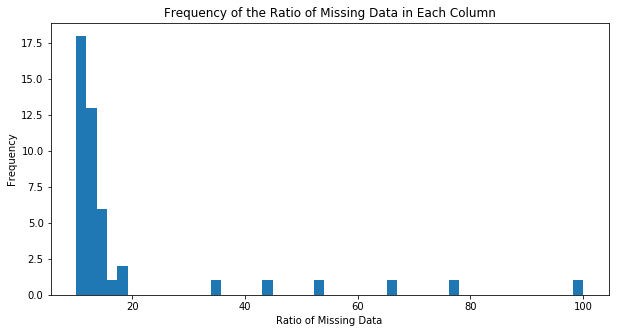

In [72]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(10,5))
plt.title('Frequency of the Ratio of Missing Data in Each Column')
plt.hist(null_per_col, bins = np.linspace(10,100,50))
plt.xlabel('Ratio of Missing Data')
plt.ylabel('Frequency')
plt.show()

In [73]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(['TITEL_KZ', 'AGER_TYP', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis = 1, inplace = True)

drop_columns = ['TITEL_KZ', 'AGER_TYP', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
for drop_column in drop_columns:
    drop_index = feat_info[feat_info['attribute'] == drop_column].index[0]
    feat_info.drop(drop_index, axis = 0, inplace = True)

In [74]:
#most common # of NaN
collections.Counter(null_total).most_common(13)

[(0, 24),
 (116515, 7),
 (4854, 6),
 (133324, 6),
 (73499, 4),
 (93148, 4),
 (111196, 3),
 (99352, 3),
 (93740, 3),
 (77792, 2),
 (158064, 2),
 (97375, 2),
 (685843, 1)]

#### Discussion 1.1.2: Assess Missing Data in Each Column

From the frequency graph above, which shows the ratio of the missing data in each column, it can be seen that majority of the columns have less than 20% missing data, and there are a few columns with more than 20% of missing data (e.g. AGER_TYP with about 77% missing data) which are outliers thus, have been removed. <br>
Another interesting observation to note is that many columns have similar numbers of missing values. As it can be seen in the cell above, the most common number of missing values is 116515 which occurs for 7 columns, followed by 133324 and 4854 for 6 columns, etc. One presumption could be that these features with similar number of missing data may in fact contain similar information and therefore it may not be necessary to keep all of these features.     

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [75]:
# How much data is missing in each row of the dataset?
azdias['Missing_num'] = azdias.isnull().sum(axis=1)
azdias['Missing_num'].describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: Missing_num, dtype: float64

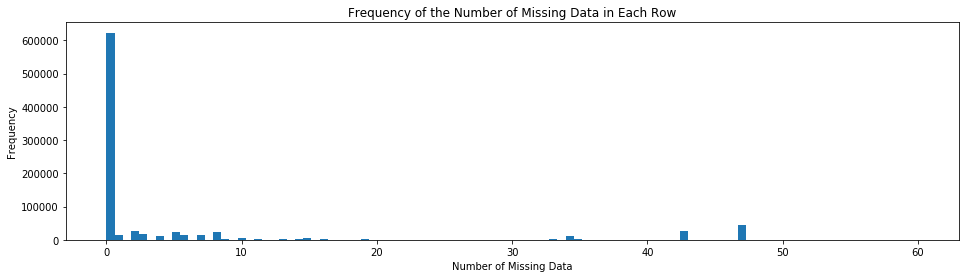

In [76]:
plt.figure(figsize=(16,4))
plt.title('Frequency of the Number of Missing Data in Each Row')
plt.hist(azdias.isnull().sum(axis = 1), bins = np.linspace(0,60,100))
plt.xlabel('Number of Missing Data')
plt.ylabel('Frequency')
plt.show()

In [77]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_1 = azdias[azdias['Missing_num'] <= 10]
azdias_2 = azdias[azdias['Missing_num'] > 10]

In [78]:
# Drop the helper feature
azdias_1 = azdias_1.drop('Missing_num', axis = 1)
azdias_2 = azdias_2.drop('Missing_num', axis = 1)
azdias = azdias.drop('Missing_num', axis = 1)

In [79]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def plot(column_name):
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    sns.set(style="darkgrid")
    ax = sns.countplot(x = column_name, data=azdias_1)
    plt.title("Group 1: <= 10 Missing Value")
    plt.subplot(122)
    sns.set(style="darkgrid")
    ax = sns.countplot(x = column_name, data=azdias_2)
    plt.title("Group 2: > 10 Missing Value")
    plt.tight_layout()

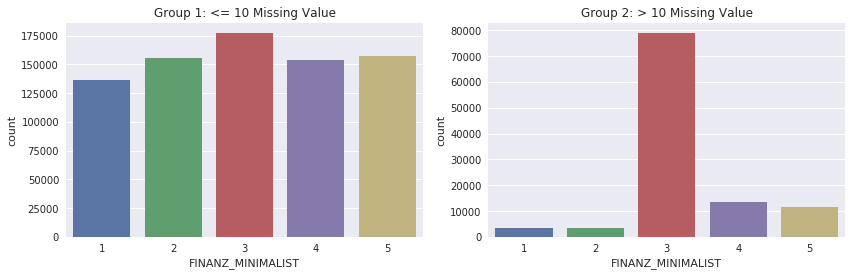

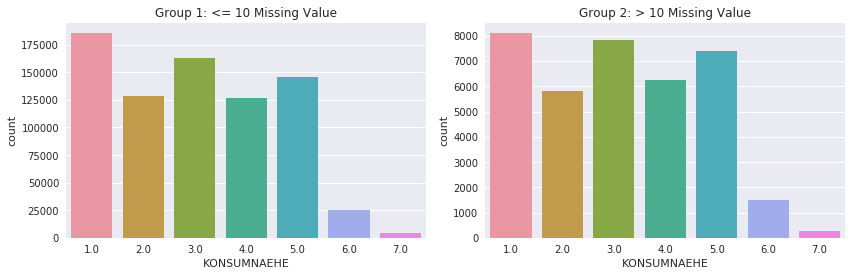

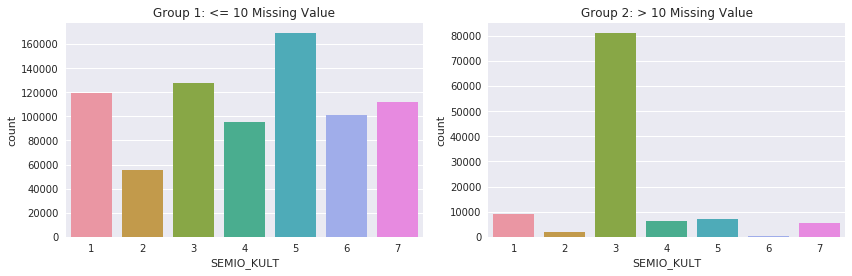

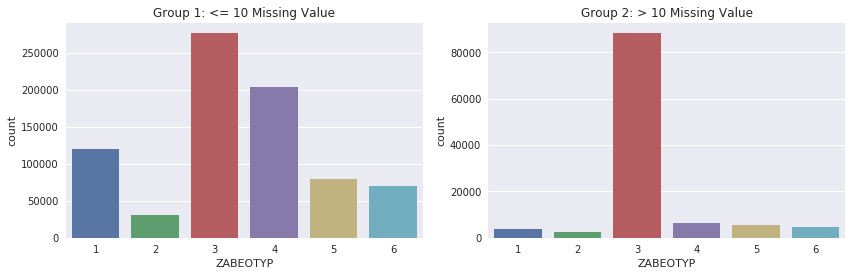

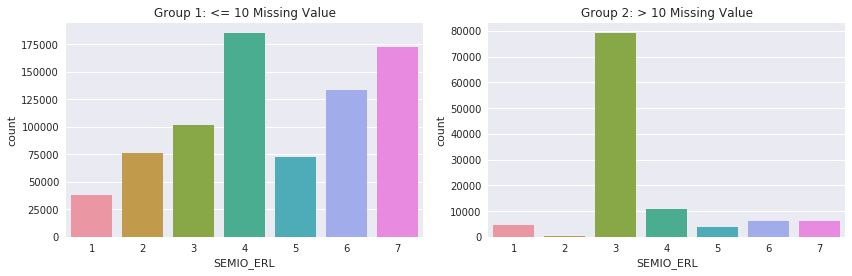

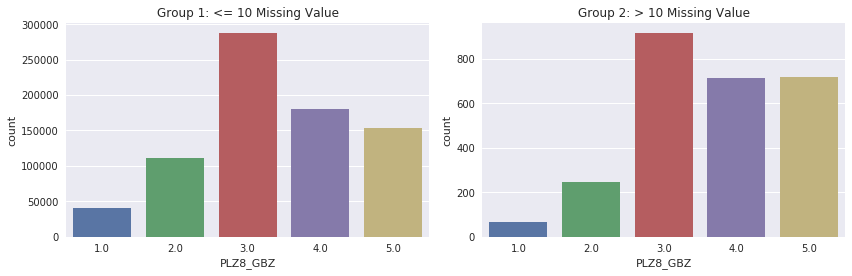

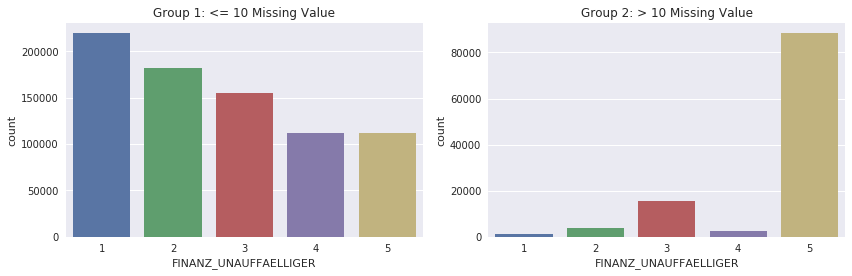

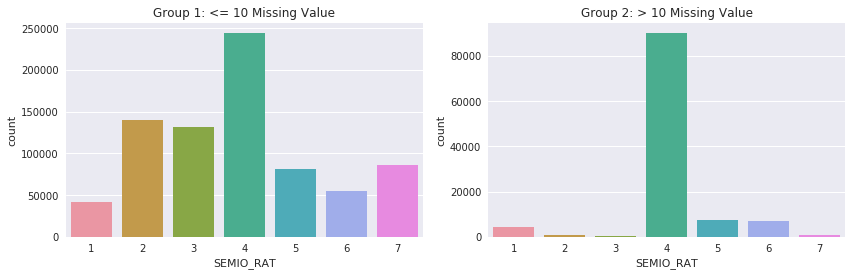

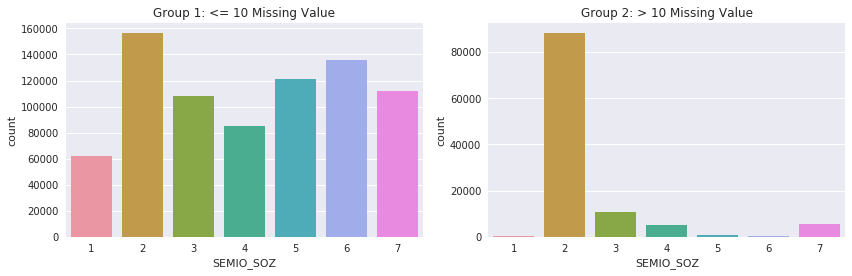

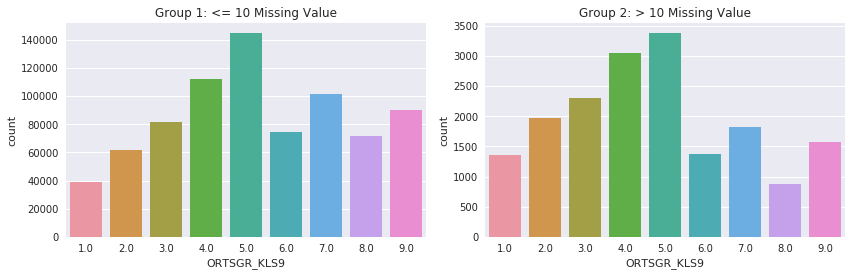

In [53]:
# 10 random columns are selected for comparisons of the distribution of 2 groups
# Sometime this will trigger an error, as some of the columns in second group could potentially be all missing values
for i in range(10):
    plot(azdias.columns[random.randint(0, 85)])

#### Discussion 1.1.3: Assess Missing Data in Each Row

As it can be seen from the frequency chart of the Number of Missing Data in Each Row, the highest numner of missing data one row may contain is around 50. Based on this chart, the original dataset was divided into two subsets with rows having greater than or less than 10 missing data.

To compare the distributions of the two subsets, 10 columns are randomly picked and the distribution of the values for both subsets are illustrated in the above cell. As it can be seen, most of these features have a different distributions and trends between the two subsets. This is more apparent for the following columns: FINANZ_UNAUFFAELLIGER, SEMIO_SOZ and SEMIO_ERL. Features as such are most helpful in separation of the two subsets and might be the key features for the final clustering task.   

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [80]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [81]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info[feat_info['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


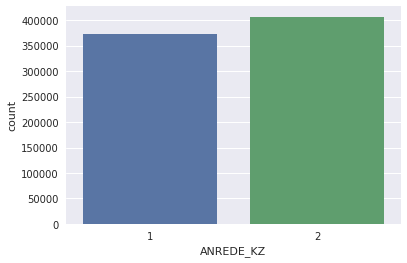

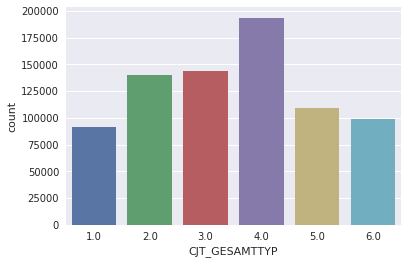

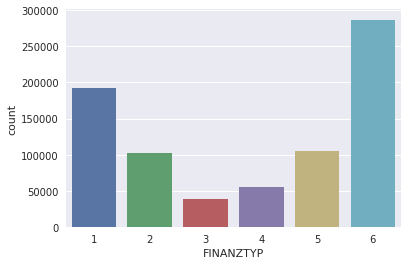

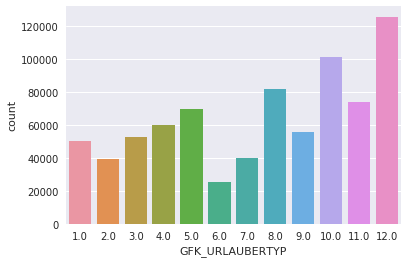

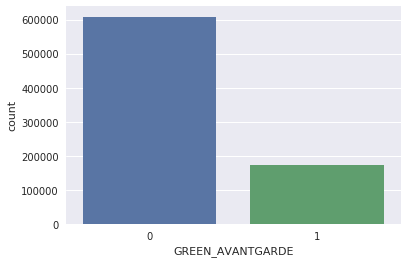

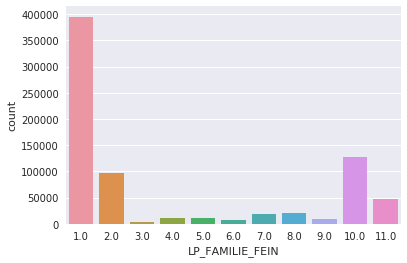

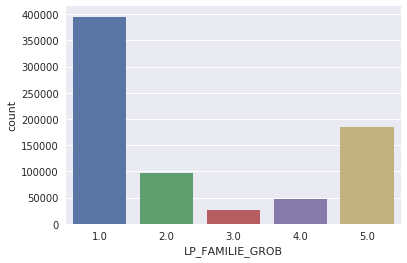

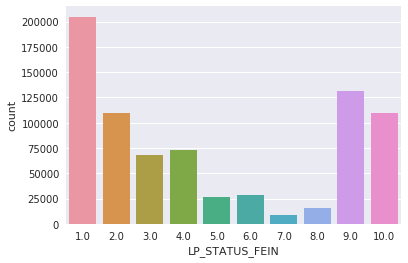

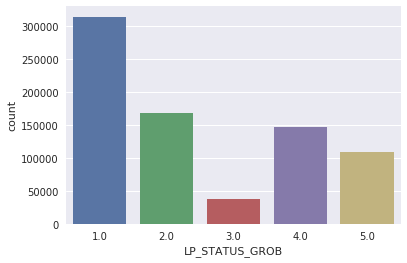

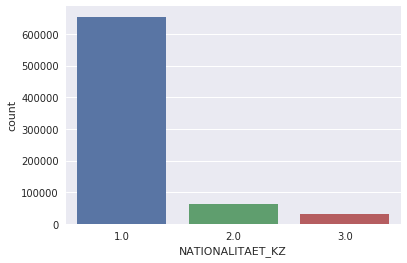

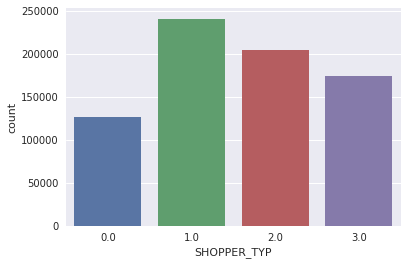

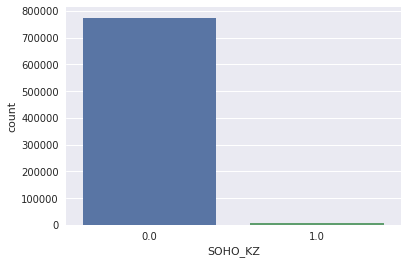

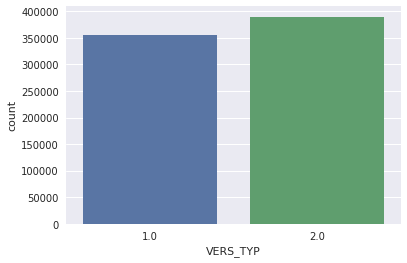

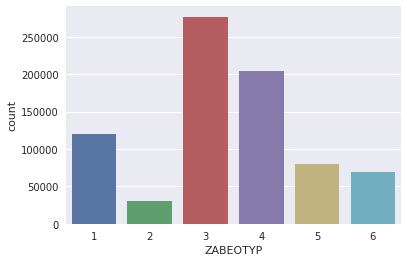

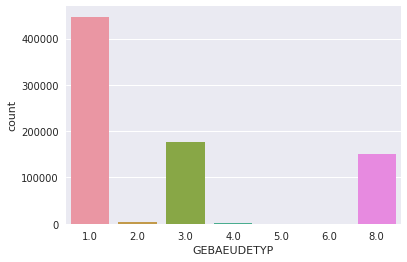

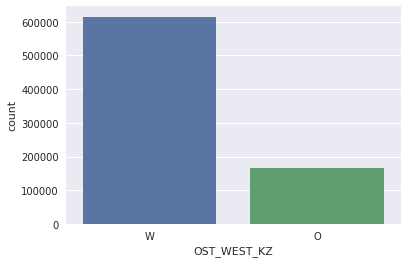

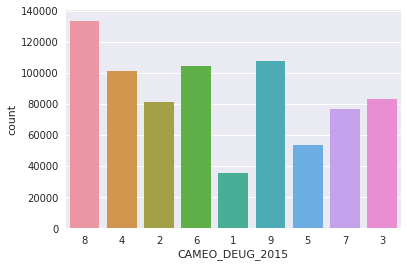

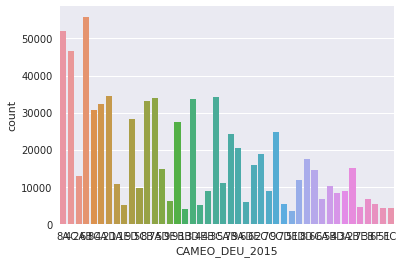

In [82]:
# Re-encode categorical variable(s) to be kept in the analysis.
for attribute in feat_info[feat_info['type'] == 'categorical']['attribute']:
    sns.set(style="darkgrid")
    ax = sns.countplot(x = attribute, data=azdias_1)
    plt.show()

In [83]:
# Drop the categorical features with >=8 values
azdias_1 = azdias_1.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis = 1)

In [84]:
#One-hot encode by using get_dummies
azdias_encode = pd.get_dummies(azdias_1, columns = ['CJT_GESAMTTYP','FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 
                                               'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'OST_WEST_KZ'])

In [85]:
azdias_encode.shape

(780153, 102)

#### Discussion 1.2.1: Re-Encode Categorical Features

Using the value_counts() for the type column in feat_info, it can be seen that there are 18 categorical features, and I decided to drop the features with >= 8 values. 

From the charts above, it can be seen that there are some binary categorical features. Except 'OST_WEST_KZ' which takes non-numeric values and needs to be one-hot encoded, there is no need to make any changes for the rest of the binary caegorical featues. The rest of  the categorical features should be one-hot encoded using get_dummies as shown above. <br> 

After re-encoding categorical features, there are 102 features left in total.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [86]:
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [87]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(azdias_encode['PRAEGENDE_JUGENDJAHRE'].value_counts())

decade_mapping = {1:40, 2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}
movement_mapping ={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}

azdias_encode['Movement'] = azdias_encode['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)
azdias_encode['Decade'] = azdias_encode['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)

14.0    178410
8.0     138678
10.0     83881
5.0      83645
3.0      53098
15.0     41029
11.0     34642
9.0      33197
6.0      25517
12.0     24034
4.0      20343
1.0      20242
2.0       7438
13.0      5561
7.0       3964
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [88]:
# Drop the original feature
azdias_encode = azdias_encode.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)

In [89]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print('value counts: %s' % azdias_encode['CAMEO_INTL_2015'].value_counts())
print('number of nulls: %s'%azdias_encode['CAMEO_INTL_2015'].isnull().sum())

value counts: 51    132853
41     91071
24     89200
14     61422
43     55836
54     45004
25     38860
22     32235
45     25771
13     25659
23     24280
55     23609
52     20388
34     18237
31     17853
15     16735
44     14593
12     12890
35     10212
32     10153
33      9636
Name: CAMEO_INTL_2015, dtype: int64
number of nulls: 3656


In [90]:
#ENGINEERING OF `CAMEO_INTL_2015`
def decode_wealth(key):
    if(len(str(key))==2):
        tens = int(str(key)[0])
        return tens
    else: return np.nan
    
def decode_life(key):
    if(len(str(key))==2):
        ones = int(str(key)[1])
        return ones
    else: return np.nan
    
azdias_encode['Wealth'] = azdias_encode['CAMEO_INTL_2015'].apply(decode_wealth)
azdias_encode['Life_Stage'] = azdias_encode['CAMEO_INTL_2015'].apply(decode_life)    

In [91]:
# Drop the original feature
azdias_encode = azdias_encode.drop('CAMEO_INTL_2015', axis = 1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

**Engineering of PRAEGENDE_JUGENDJAHRE:**

 - Created mapping from PRAEGENDE_JUGENDJAHRE to a new categorical variable named Decade.
 
 - Created mapping from PRAEGENDE_JUGENDJAHRE to a new binary variable named Movement.
 
 - Dropped the original PRAEGENDE_JUGENDJAHRE variable.
 
**Engineering of CAMEO_INTL_2015:**

 - Using decode_wealth function which returns the first digit of the original variable, created a new ordinal variable named Wealth.
 - Using decode_life function which returns the second digit of the original variable, created a new ordinal variable named Life_Stage.
 - Dropped the original CAMEO_INTL_2015 variable.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [92]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Drop Other mixed Features for now. I can always come back and add these if it is necessary.
azdias_encode.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 
                              'WOHNLAGE', 'PLZ8_BAUMAX'],
                   axis = 1, inplace = True)

Number of features left after cleaning steps: 100


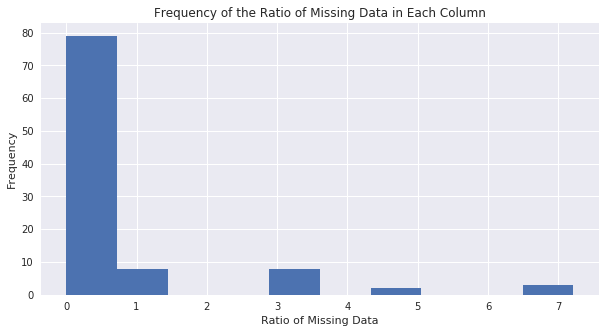

In [93]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# To simplify the notation
df = azdias_encode

print('Number of features left after cleaning steps: {}'.format(df.shape[1]))

#Let's see how the frequency of missing data in each column looks like now
null_total = df.isnull().sum()
null_per_col = 100 * (null_total / len(df))
plt.figure(figsize=(10,5))
plt.title('Frequency of the Ratio of Missing Data in Each Column')
plt.hist(null_per_col)
plt.xlabel('Ratio of Missing Data')
plt.ylabel('Frequency')
plt.show()


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [94]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    for i, column in enumerate(df.columns):
        str_n = feat_info['missing_or_unknown'].iloc[i]
        if i in [57, 58, 59]:
            list_n = str_n[1: -1].split(',')
        else:
            list_n = ast.literal_eval(str_n)
        for num in list_n:
            df[column].replace(num, np.NaN, inplace = True)
    
    # remove selected columns and rows, ...
    drop_columns = ['TITEL_KZ', 'AGER_TYP', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(drop_columns, axis = 1, inplace = True)
    
    df['Missing_num'] = df.isnull().sum(axis=1)
    df_1 = df[df['Missing_num'] <= 10]
    df_1 = df_1.drop('Missing_num', axis = 1)
    
    # select, re-encode, and engineer column values.
    df_1 = pd.get_dummies(df_1, columns = ['CJT_GESAMTTYP','FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 
                                               'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'OST_WEST_KZ'])
    df = df_1.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis = 1)
    
    #engineer mixed features
    decade_mapping = {1:40, 2:40,3:50,4:50,5:60,6:60,7:60,8:70,
                      9:70,10:80,11:80,12:80,13:80,14:90,15:90}
    movement_mapping ={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,
                         9:1,10:0,11:1,12:0,13:1,14:0,15:1}
    
    df['Movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)
    df['Decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
    
    df['Wealth'] = df['CAMEO_INTL_2015'].apply(decode_wealth)
    df['Life_Stage'] = df['CAMEO_INTL_2015'].apply(decode_life)  
    df = df.drop('CAMEO_INTL_2015', axis = 1)
    
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis = 1, inplace = True)
        
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [95]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#impute all variables using mode since many are categorical or binary
imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
df = pd.DataFrame(imputer.fit_transform(df),
                              index=df.index, columns=df.columns)

# Check all 'NAN's are transformed or not
df.isnull().sum().sum()

0

In [96]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

scaled_azdias = pd.DataFrame(scaler.fit_transform(df),
                              index=df.index, columns=df.columns)

In [97]:
# Check StandardScalar
scaled_azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,OST_WEST_KZ_O,OST_WEST_KZ_W,Movement,Decade,Wealth,Life_Stage
count,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,...,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05,7.801530e+05
mean,-2.010715e-16,4.519714e-17,1.012780e-16,7.527544e-17,8.963834e-17,1.339657e-16,9.701560e-17,-1.161965e-16,-8.288040e-17,-6.384523e-17,...,-5.663190e-17,1.210418e-17,-1.741399e-17,-2.975497e-17,6.870876e-17,-1.216793e-16,-8.288040e-17,-3.617410e-16,1.019156e-16,8.756177e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.767651e+00,-1.043411e+00,-1.488140e+00,-1.151087e+00,-1.771610e+00,-1.247812e+00,-1.172510e+00,-1.532818e+00,-5.311987e-01,-1.638593e+00,...,-7.412825e-01,-5.944357e-01,-3.369173e-01,-3.134834e-01,-5.187691e-01,-1.927640e+00,-5.311987e-01,-2.307269e+00,-1.556031e+00,-1.249732e+00
25%,-7.847811e-01,-1.043411e+00,-7.624505e-01,-1.151087e+00,-1.045251e+00,-1.247812e+00,-1.172510e+00,-8.178947e-01,-5.311987e-01,-3.161576e-01,...,-7.412825e-01,-5.944357e-01,-3.369173e-01,-3.134834e-01,-5.187691e-01,5.187691e-01,-5.311987e-01,-9.422475e-01,-8.742748e-01,-1.249732e+00
50%,1.980888e-01,9.583948e-01,-3.676105e-02,1.939963e-01,4.074683e-01,1.097306e-01,-4.549831e-01,-1.029710e-01,-5.311987e-01,-3.161576e-01,...,-7.412825e-01,-5.944357e-01,-3.369173e-01,-3.134834e-01,-5.187691e-01,5.187691e-01,-5.311987e-01,4.227735e-01,4.892383e-01,9.266022e-02
75%,1.180959e+00,9.583948e-01,6.889284e-01,8.665379e-01,1.133828e+00,7.885020e-01,9.800714e-01,6.119528e-01,-5.311987e-01,1.006277e+00,...,1.349013e+00,1.682268e+00,-3.369173e-01,-3.134834e-01,-5.187691e-01,5.187691e-01,-5.311987e-01,1.105284e+00,1.170995e+00,7.638562e-01
max,1.180959e+00,9.583948e-01,1.414618e+00,1.539080e+00,1.133828e+00,1.467273e+00,1.697599e+00,1.326876e+00,1.882535e+00,1.006277e+00,...,1.349013e+00,1.682268e+00,2.968088e+00,3.189962e+00,1.927640e+00,5.187691e-01,1.882535e+00,1.105284e+00,1.170995e+00,1.435052e+00


### Discussion 2.1: Apply Feature Scaling

In this section, firstly, Imputer was used to fill 'NaN' with mode value in each column. The mode method was used instead of the default method of mean, as most of the values are categorical or binary, and there are not many numerical/continuous features. <br> After dealing with the 'NaN' values, the standardscalar was used to scale original columns to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [98]:
# Apply PCA to the data.
pca = PCA()
df_pca = pca.fit_transform(scaled_azdias)

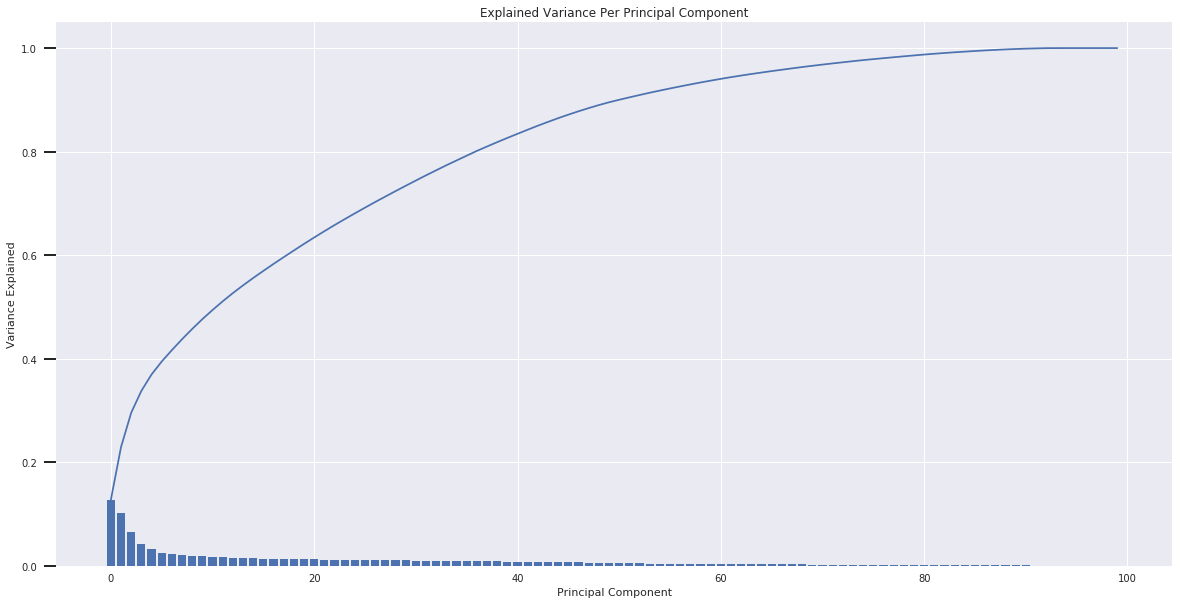

In [99]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    plt.title('Explained Variance Per Principal Component')


scree_plot(pca)


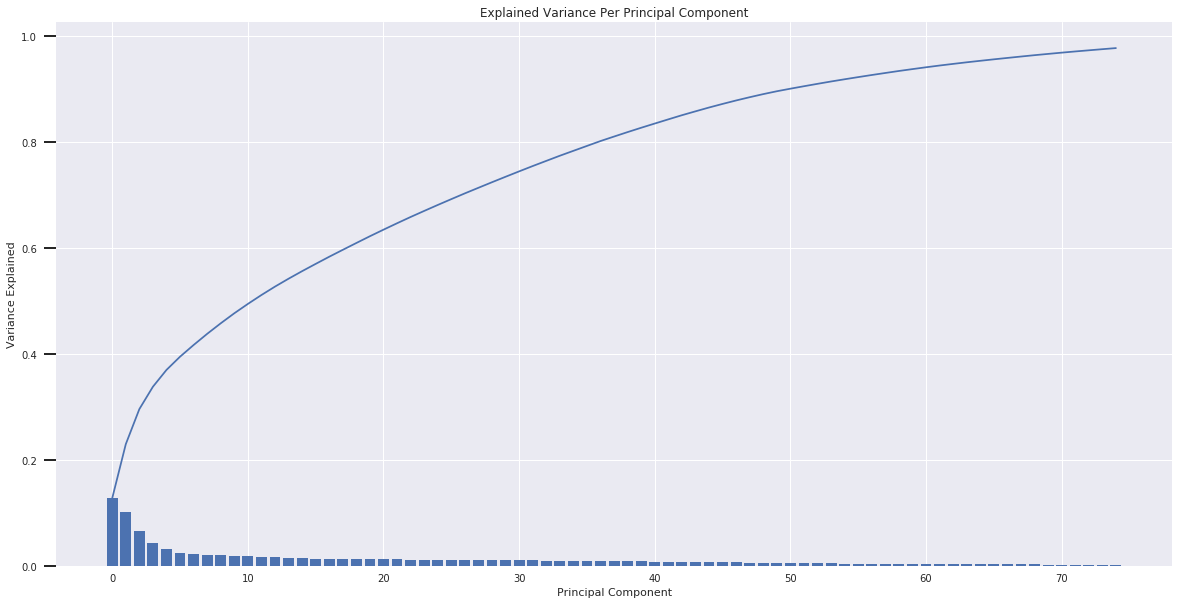

In [101]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(75)
df_pca = pca.fit_transform(scaled_azdias)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

As it can be seen in the above scree plots, 75 principal components explain a cumulative variance of more than 95%, and I believe it should be good enough number of principal components to keep.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [102]:
def print_weights(n):
    '''
    n: number of principal component
    '''
    components = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = df.keys())
    components.index = ['Weights']
    components = components.sort_values(by = 'Weights', axis = 1, ascending=False)
    components = components.T
    print(components)
    return components

In [103]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

components_1 = print_weights(1)

                       Weights
LP_STATUS_GROB_1.0      0.2024
HH_EINKOMMEN_SCORE      0.1863
PLZ8_ANTG3              0.1859
PLZ8_ANTG4              0.1791
Wealth                  0.1759
FINANZ_SPARER           0.1703
ORTSGR_KLS9             0.1596
EWDICHTE                0.1576
FINANZTYP_1             0.1494
FINANZ_HAUSBAUER        0.1413
SEMIO_PFLICHT           0.1338
Decade                  0.1323
SEMIO_REL               0.1295
KBA05_ANTG4             0.1285
PLZ8_ANTG2              0.1267
KBA05_ANTG3             0.1201
ARBEIT                  0.1161
ANZ_HAUSHALTE_AKTIV     0.1143
SEMIO_RAT               0.1127
RELAT_AB                0.1091
SEMIO_TRADV             0.1084
FINANZ_UNAUFFAELLIGER   0.1025
FINANZ_ANLEGER          0.1005
ZABEOTYP_5              0.1002
SEMIO_MAT               0.0866
SEMIO_FAM               0.0814
SEMIO_KULT              0.0803
LP_FAMILIE_GROB_1.0     0.0750
ZABEOTYP_4              0.0619
NATIONALITAET_KZ_2.0    0.0608
...                        ...
FINANZTY

In [104]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

components_2 = print_weights(2)

                       Weights
ALTERSKATEGORIE_GROB    0.2141
ZABEOTYP_3              0.2026
FINANZ_VORSORGER        0.1977
SEMIO_ERL               0.1857
SEMIO_LUST              0.1505
RETOURTYP_BK_S          0.1505
FINANZ_HAUSBAUER        0.1340
W_KEIT_KIND_HH          0.1237
PLZ8_ANTG3              0.1180
PLZ8_ANTG4              0.1122
ORTSGR_KLS9             0.1067
EWDICHTE                0.1065
Wealth                  0.1019
CJT_GESAMTTYP_2.0       0.0991
SEMIO_KRIT              0.0963
FINANZTYP_5             0.0921
SEMIO_KAEM              0.0914
HH_EINKOMMEN_SCORE      0.0885
KBA05_ANTG4             0.0879
ARBEIT                  0.0833
PLZ8_ANTG2              0.0799
ANZ_HAUSHALTE_AKTIV     0.0778
RELAT_AB                0.0766
LP_STATUS_GROB_1.0      0.0736
SHOPPER_TYP_3.0         0.0735
LP_FAMILIE_GROB_1.0     0.0722
FINANZTYP_2             0.0715
ANREDE_KZ               0.0678
CJT_GESAMTTYP_1.0       0.0665
KBA05_ANTG3             0.0654
...                        ...
SHOPPER_

In [105]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

components_3 = print_weights(3)

                       Weights
SEMIO_VERT              0.3251
SEMIO_SOZ               0.2580
SEMIO_FAM               0.2555
SEMIO_KULT              0.2422
FINANZTYP_5             0.1429
FINANZ_MINIMALIST       0.1287
SHOPPER_TYP_0.0         0.1249
ZABEOTYP_1              0.1019
SEMIO_REL               0.0968
RETOURTYP_BK_S          0.0914
W_KEIT_KIND_HH          0.0789
SEMIO_MAT               0.0767
FINANZ_VORSORGER        0.0698
ORTSGR_KLS9             0.0629
EWDICHTE                0.0622
PLZ8_ANTG3              0.0594
PLZ8_ANTG4              0.0584
ZABEOTYP_6              0.0545
SHOPPER_TYP_1.0         0.0496
GREEN_AVANTGARDE        0.0491
Movement                0.0491
ARBEIT                  0.0430
PLZ8_ANTG2              0.0408
RELAT_AB                0.0399
ALTERSKATEGORIE_GROB    0.0399
SEMIO_LUST              0.0378
Wealth                  0.0349
KBA05_ANTG4             0.0339
LP_STATUS_GROB_5.0      0.0314
ANZ_HAUSHALTE_AKTIV     0.0304
...                        ...
ZABEOTYP

### Discussion 2.3: Interpret Principal Components

Each principal component is a unit vector that points in the direction of highest variance after accounting for the variance captured by earlier principal components. If two features have large weights of the same sign (both positive or both negative), then the two features tend to be positively correlated. In contrast, features with different signs tend to show a negative correlation. <br>

For the first principal component, it can be seen that LP_STATUS_GROB_1.0 (low-income earners) has a weight of 0.2024, while FINANZ_MINIMALIST (Financial typology) has a weight of -0.2226. This shows that the two features have high negative correlation. This is not surprising because Financial typology shows the lack of interest of someone in finance, which has an obvious negative correlation to wealth.

The second principal component is explained mostly by: ALTERSKATEGORIE_GROB,  FINANZ_VORSORGER, ZABEOTYP_3, and the least by: Decade, FINANZ_UNAUFFAELLIGER, SEMIO_REL. There is a mixture of age, financial awareness, and environmental/religious awareness respectively.

Many of the features that explain the third principal component relate to personality typology. The most explanatory feature is SEMIO_VERT which is a measure of 'dreamfulness', followed by SEMIO_SOZ: socially-mindedness and SEMIO_FAM: family-mindedness. At the bottom, the features are: ANREDE_KZ which shows gender, SEMIO_KAEM which is a combative-minded feature and SEMIO_DOM which is a dominant-minded feature.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

   - Use sklearn's [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
   - Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's .score() method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
   - Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
   - Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.


In [106]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [46]:
# Over a number of different cluster counts...
scores = []

for i in range(2, 21, 2):
    # run k-means clustering on the data and...    
    # compute the average within-cluster distances.
    scores.append(score(df_pca, i))   


     

In [107]:
clusters = [2,4,6,8,10,12,14,16,18,20]

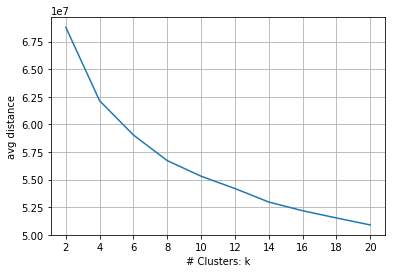

In [49]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

fig, ax = plt.subplots()
ax.plot(clusters, scores)
ax.set(ylabel='avg distance', xlabel='# Clusters: k')
ax.grid()
plt.xticks(np.arange(2,21,2))
plt.show()

In [108]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(10).fit(df_pca)
kmeans_pred = kmeans.predict(df_pca)

### Discussion 3.1: Apply Clustering to General Population

As it can be seen in the above scree-plot, there is not a specific kink in the graph and the average distance keeps decreasing. However, in my view, after cluster 10, the average distance is starting to level out and that is why I picked the number of clusters to be 10 for the rest of analysis.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [109]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [110]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers)

customer_reduced = pca.transform(scaler.transform(imputer.transform(customers_cleaned)))

customer_clusters = kmeans.predict(customer_reduced)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [111]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
gen_pop = scaled_azdias.shape[0]
gen_pop_all = azdias.shape[0] #including all dropped high NaN data

customer_pop = customers_cleaned.shape[0]
customer_pop_all = customers.shape[0] #including all customers with high NaN data

gen_pop_cluster_count = np.bincount(kmeans_pred)
customer_cluster_count = np.bincount(customer_clusters)

gen_pop_cluster_prop = [x/gen_pop for x in gen_pop_cluster_count]
customer_cluster_prop = [x/customer_pop for x in customer_cluster_count]

In [112]:
prop_data = pd.DataFrame({'gen_pop': gen_pop_cluster_prop, 'customers': customer_cluster_prop}, index=np.arange(1,11))
prop_data.index.names=['Cluster']

In [113]:
#create data frame where each entry in `gen_pop` is % of gen_pop in a cluster
# each entry in `customers` is% of customer population in a cluster
prop_data_all = pd.DataFrame({'gen_pop': [x/gen_pop_all for x in gen_pop_cluster_count], 
                              'customers': [x/customer_pop_all for x in customer_cluster_count]},
                             index=np.arange(1,11))
prop_data_all.index.names=['Cluster']

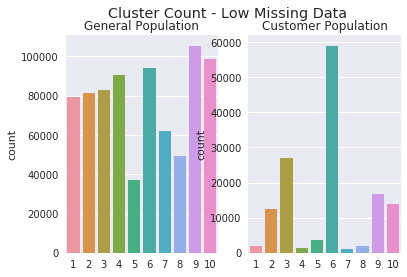

In [125]:
# Cluster Count - Low Missing Data'''

plt.figure(figsize=(14,4))
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False)
fig.suptitle('Cluster Count - Low Missing Data')
ax1.set_title('General Population')
ax2.set_title('Customer Population')
sns.countplot(kmeans_pred+1, ax=ax1)
sns.countplot(customer_clusters+1, ax=ax2)
plt.show()

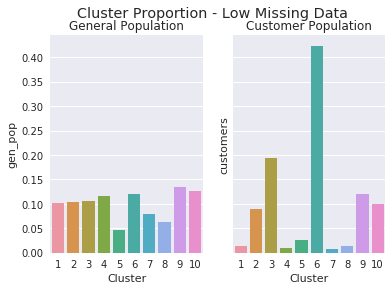

In [124]:
#Cluster Proportion - Low Missing Data

plt.figure(figsize=(14,4))
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.suptitle('Cluster Proportion - Low Missing Data')
ax1.set_title('General Population')
ax2.set_title('Customer Population')
sns.barplot(x=prop_data.index, y=prop_data.gen_pop, ax=ax1)
sns.barplot(x=prop_data.index, y=prop_data.customers, ax=ax2)
plt.show()

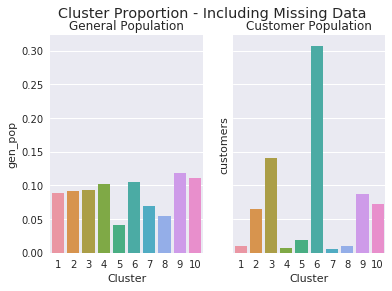

In [126]:
#Cluster Proportion - All Data'''

plt.figure(figsize=(14,4)) 
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.suptitle('Cluster Proportion - Including Missing Data')
ax1.set_title('General Population')
ax2.set_title('Customer Population')
sns.barplot(x=prop_data_all.index, y=prop_data_all.gen_pop, ax=ax1)
sns.barplot(x=prop_data_all.index, y=prop_data_all.customers, ax=ax2)
plt.show()

In [127]:
#What kinds of people are part of a cluster that is overrepresented 
#in the customer data compared to the general population?

rep = {}

print('\n Cluster Representation - Low Missing Data\n----------\n')
for i in np.arange(0,10):
    a = customer_cluster_prop[i]
    b = gen_pop_cluster_prop[i]
    rep[i+1] = (a-b)*100

for x in rep:
    if(rep[x]>0):
        print('Cluster %s: OVER represented by %.2f%%'% (x, rep[x]))
    elif(rep[x]<0):
        print('Cluster %s: UNDER represented by %.2f%%'% (x, rep[x]))


 Cluster Representation - Low Missing Data
----------

Cluster 1: UNDER represented by -8.70%
Cluster 2: UNDER represented by -1.42%
Cluster 3: OVER represented by 8.72%
Cluster 4: UNDER represented by -10.56%
Cluster 5: UNDER represented by -2.04%
Cluster 6: OVER represented by 30.30%
Cluster 7: UNDER represented by -7.15%
Cluster 8: UNDER represented by -4.94%
Cluster 9: UNDER represented by -1.51%
Cluster 10: UNDER represented by -2.69%


In [128]:
full_rep = {}

print('\n Cluster Over Representation - Full Population including Missing Data \n----------\n')
for i in np.arange(0,10):
    a = prop_data_all.customers.iloc[i]
    b = prop_data_all.gen_pop.iloc[i]
    full_rep[i+1] = (a-b)*100

for x in full_rep:
    if(full_rep[x]>0):
        print('Cluster %s: OVER represented by %.2f%%'% (x, full_rep[x]))
    elif(full_rep[x]<0):
        print('Cluster %s: UNDER represented by %.2f%%'% (x, full_rep[x]))


 Cluster Over Representation - Full Population including Missing Data 
----------

Cluster 1: UNDER represented by -7.84%
Cluster 2: UNDER represented by -2.59%
Cluster 3: OVER represented by 4.74%
Cluster 4: UNDER represented by -9.40%
Cluster 5: UNDER represented by -2.18%
Cluster 6: OVER represented by 20.18%
Cluster 7: UNDER represented by -6.37%
Cluster 8: UNDER represented by -4.53%
Cluster 9: UNDER represented by -3.12%
Cluster 10: UNDER represented by -3.85%


In [119]:
def cluster_centers(cluster):
    cluster_center = np.around(kmeans.cluster_centers_[cluster-1], decimals=2)
    clusters_sorted = cluster_center[np.argsort(cluster_center)[:]]
    pca_undone=np.around(pca.inverse_transform(kmeans.cluster_centers_[cluster-1]), 
                                                 decimals=2)
    pca_undone_sorted = pca_undone[np.argsort(pca_undone)[:]]
    print('Cluster %s' % cluster)
    print('sorted array\n-----\n Top 3: %s \n Bottom 3: %s '% (np.flip(clusters_sorted[-3:],0), 
                                                               clusters_sorted[:3]))
    print('\n original array\n-----\n %s'% cluster_center)
    
    print('PCA sorted\n-----\n Top 3: %s \n Bottom 3: %s '% (np.flip(pca_undone_sorted[-3:],0), 
                                                               pca_undone_sorted[:3]))
    print('\n PCA Undone\n-----\n %s'% pca_undone)

In [129]:
cluster_centers(cluster=6)

Cluster 6
sorted array
-----
 Top 3: [ 2.87  0.65  0.63] 
 Bottom 3: [-4.29 -0.6  -0.5 ] 

 original array
-----
 [-4.29  0.24  0.63  2.87  0.25 -0.6  -0.08 -0.23  0.   -0.05  0.65 -0.5  -0.
 -0.01 -0.47  0.22  0.19  0.39 -0.17 -0.34  0.26 -0.21  0.34 -0.16 -0.03
 -0.02  0.01 -0.14  0.19 -0.08  0.16 -0.06 -0.06  0.01  0.1   0.04 -0.17
  0.05  0.1   0.09 -0.16 -0.07  0.11  0.08  0.24  0.08 -0.11  0.01 -0.06
 -0.04  0.05 -0.05  0.03 -0.08 -0.05  0.07  0.07  0.04  0.1   0.06 -0.05
 -0.09 -0.02  0.    0.04 -0.    0.04 -0.01 -0.01  0.    0.03 -0.01 -0.
  0.01 -0.01]
PCA sorted
-----
 Top 3: [ 2.04  1.86  1.86] 
 Bottom 3: [-1.4  -0.85 -0.82] 

 PCA Undone
-----
 [ 0.58 -0.08  1.15 -0.81  0.68 -0.76 -0.48 -0.75  1.86 -0.2   0.25 -0.05
 -0.35 -0.53 -0.36  0.24  0.45  0.29 -0.31 -0.45 -0.09  0.06 -0.07 -0.56
 -0.41  0.01 -0.07  0.45  0.12 -1.4  -0.11  0.35 -0.44 -0.07  0.27 -0.05
  0.95 -0.14 -0.56 -0.46  0.75 -0.04 -0.02  0.07  0.29 -0.56  0.89  0.3
 -0.57  0.22  0.59 -0.29 -0.45 -0.45  0.07 

In [130]:
cluster_centers(cluster=3)

Cluster 3
sorted array
-----
 Top 3: [ 1.69  0.44  0.38] 
 Bottom 3: [-3.46 -2.01 -0.55] 

 original array
-----
 [-3.46 -0.5   1.69 -2.01  0.13  0.44 -0.42  0.27 -0.02  0.19  0.21  0.12
  0.26 -0.01  0.38 -0.55 -0.08 -0.35  0.02 -0.   -0.04 -0.02 -0.01  0.01
 -0.15  0.1   0.05 -0.08  0.05 -0.06  0.03 -0.1   0.12 -0.03  0.15 -0.14
  0.03  0.22 -0.04  0.05  0.09  0.02  0.29 -0.07  0.04  0.07 -0.17 -0.05
 -0.05 -0.13 -0.   -0.03  0.08 -0.06 -0.02 -0.05 -0.01  0.03 -0.02 -0.05
 -0.04  0.07 -0.09  0.11 -0.    0.06 -0.   -0.04  0.06 -0.05 -0.02 -0.
 -0.02  0.05  0.01]
PCA sorted
-----
 Top 3: [ 1.32  1.1   0.85] 
 Bottom 3: [-0.89 -0.88 -0.86] 

 PCA Undone
-----
 [ 0.48 -0.89  1.1  -0.7   0.6  -0.51 -0.62 -0.72 -0.47  0.12  0.24  0.28
  0.33 -0.09 -0.25  0.85  0.24 -0.16  0.43 -0.64 -0.54 -0.66 -0.88 -0.49
 -0.35  0.    0.11  0.1  -0.03 -0.38  0.06  0.18 -0.38 -0.11  0.62  0.2
  0.63 -0.07 -0.46 -0.44  0.7   0.55 -0.86  0.66  0.34  0.18  0.72 -0.07
  0.09  0.12  0.69 -0.59 -0.79 -0.7  -0.3

In [122]:
cluster_centers(cluster=4)

Cluster 4
sorted array
-----
 Top 3: [ 5.03  0.5   0.36] 
 Bottom 3: [-2.33 -0.62 -0.57] 

 original array
-----
 [ 5.03 -0.62 -2.33  0.5  -0.08 -0.01 -0.07 -0.15  0.09  0.36 -0.02 -0.57
  0.11  0.08 -0.04 -0.34  0.17  0.05 -0.16 -0.23 -0.1   0.06  0.1  -0.12
 -0.15  0.04 -0.08 -0.04  0.04 -0.07  0.03 -0.05 -0.08  0.05  0.06  0.08
  0.15  0.05  0.04  0.07 -0.05  0.    0.05  0.03  0.01  0.11 -0.19 -0.05
 -0.04 -0.09 -0.   -0.03  0.02  0.02 -0.01  0.03 -0.02  0.03 -0.01 -0.01
  0.   -0.04 -0.11  0.07 -0.    0.02  0.06 -0.01  0.07 -0.07  0.02 -0.05
 -0.02  0.    0.03]
PCA sorted
-----
 Top 3: [ 1.31  1.28  1.09] 
 Bottom 3: [-1.37 -1.04 -0.96] 

 PCA Undone
-----
 [-0.96  0.91 -1.37  1.09 -0.87  0.89  0.81  0.76 -0.46  0.14 -0.52 -0.49
 -0.03  0.76  0.42 -1.04 -0.47 -0.06  0.01  1.31  0.53  0.9   0.97  0.96
  0.91 -0.01  0.03 -0.24 -0.03  0.74 -0.02 -0.35  0.41  0.06 -0.56 -0.23
 -0.76  0.06  0.55  0.5  -0.75 -0.42  0.69 -0.56 -0.36  0.17 -0.78  0.1
  0.22 -0.25 -0.75  0.55  0.77  0.76  0

### Discussion 3.3: Compare Customer Data to Demographics Data

Whether all population data including Missing Data or low Missing Data is considered for comparisons between customer data and the general population data, it can be seen in the above that clusters 3 and 6 were over-represented in the customer data and cluster 4 was the highest under-represented cluster in the customer data. 

To evaluate which features define each cluster the most, the inverse transformation of the PCA: pca.inverse_transform is used to get us back the original features. Here are some insights can be given: 

**Over-Represented Cluster: #6** <br>

LP_STATUS_GROB_5.0 is the highest impact feature in the 6th cluster, which represents the top earners. Furthermore, GREEN_AVANTGARDE is the second feature with the highest impact in the 6th cluster. It represents participation and interest in environmental issues during a person's youth.
The least impactful feature in the 8th cluster is HH_EINKOMMEN_SCORE, which again proves the point that high income and status is the biggest definer of this cluster. Therefore, people with a high income who are also environmentally conscious are highly over represented in the customer data and thus this group is a good target audience for market campaining.

**Over-Represented Cluster: #3** <br>

Two of the highest impactful features of cluster 3 are:

LP_STATUS_GROB_4.0: houseowners
SEMIO_VERT: dreamful

LP_STATUS_GROB_4.0 is similar to LP_STATUS_GROB_5.0 in cluster 6 and SEMIO_VERT is a measure of 'dreamfulness' as discussed before.

**Under-Represented Cluster: #4** <br>

SEMIO_RAT which represents rationality (higher values means less rational) along with FINANZTYP_1 which represents people who are not interested in finance are the top 2 most impactful features in this cluster. 

Overall, it can be concluded that lower income people who are irrational and not interested in finance are under-represented in the customer data. This makes sense, especially since this is a financial services company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.